In [45]:
import warnings
warnings.filterwarnings("ignore")

In [46]:
import os
import time
import sklearn
from random import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from tabulate import tabulate
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

evaluate={'Acc':"Accuracy", 'b_Acc':"Balanced Accuracy", 'F1':"F1 Score", 'kap':"Kappa", 'ROC':"Roc"}

In [47]:
from sklearn.tree import DecisionTreeClassifier


In [48]:
def folder(f_name): #this function creates a folder named "attacks" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

In [49]:
def find_the_way(path,file_format,con=""):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))  
    return files_add

In [50]:
ml_list={"DT":{"UDP":DecisionTreeClassifier(),"Mirai":DecisionTreeClassifier(),"VI":DecisionTreeClassifier()}}

In [51]:
find_the_way("./",".csv")

['./comple.csv',
 './sonuç_size.csv',
 './sonuç_ts.csv',
 './complexity\\sonuç_size.csv',
 './complexity\\sonuç_ts.csv',
 './csvs\\DoS-SYN-1.csv',
 './csvs\\DoS-SYN-2.csv',
 './csvs\\DoS-SYN-3.csv',
 './csvs\\DoS-SYN-4.csv',
 './csvs\\DoS-SYN-5.csv',
 './csvs\\DoS-SYN-6.csv',
 './csvs\\Kitsune_Mirai_FE.csv',
 './csvs\\MB-ACK-1.csv',
 './csvs\\MB-ACK-2.csv',
 './csvs\\MB-ACK-3.csv',
 './csvs\\MB-ACK-4.csv',
 './csvs\\MB-BF-1.csv',
 './csvs\\MB-BF-2.csv',
 './csvs\\MB-BF-3.csv',
 './csvs\\MB-BF-4.csv',
 './csvs\\MB-BF-5.csv',
 './csvs\\MB-HDis-1.csv',
 './csvs\\MB-HDis-2.csv',
 './csvs\\MB-HDis-3.csv',
 './csvs\\MB-HDis-4.csv',
 './csvs\\MB-HDis-5.csv',
 './csvs\\MB-HTTP-1.csv',
 './csvs\\MB-HTTP-2.csv',
 './csvs\\MB-HTTP-3.csv',
 './csvs\\MB-HTTP-4.csv',
 './csvs\\MB-UDP-1.csv',
 './csvs\\MB-UDP-2.csv',
 './csvs\\MB-UDP-3.csv',
 './csvs\\MB-UDP-4.csv',
 './csvs\\MitM-ARP-1.csv',
 './csvs\\MitM-ARP-2.csv',
 './csvs\\MitM-ARP-3.csv',
 './csvs\\MitM-ARP-4.csv',
 './csvs\\MitM-ARP-5.csv',
 

In [52]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    target_names=sorted(list(df["Label"].unique()))
    return target_names

In [53]:
folder("results")
folder("pdfs")
folder("results/fin")
folder("models")


## Calculation of evaluations

In [54]:
def score(train_time,test_time,predict,y_test,class_based_results,repeat,cv,dname,ml,sw):
    train_time=train_time[0]
    test_time=test_time[0]
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")     
    accuracy=sklearn.metrics.accuracy_score(y_test, predict)
    accuracy_b=sklearn.metrics.balanced_accuracy_score( y_test,predict)
    kappa=sklearn.metrics.cohen_kappa_score(y_test, predict,labels=None, weights=None, sample_weight=None)
    try:
        roc=sklearn.metrics.roc_auc_score(y_test, predict)
    except:roc=0
    report = sklearn.metrics.classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    line=[dname,sw,repeat,cv,ml,accuracy,accuracy_b,pr,rc,f_1,kappa,roc,train_time,test_time]

    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    return class_based_results,line

In [55]:
def ML(loop1,loop2,output_csv,cols,dname,sw):
    fold=5
    repetition=100
    for ii in ml_list:
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Attack","Feature","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        for i in range(repetition):

                df = pd.read_csv(loop1,usecols=cols)#,header=None )
                df=df.fillna(0)
                X_train =df[df.columns[0:-1]]
                X_train=np.array(X_train)
                df[df.columns[-1]] = df[df.columns[-1]].astype('category')
                y_train=df[df.columns[-1]].cat.codes  


                df = pd.read_csv(loop2,usecols=cols)#,header=None )
                df=df.fillna(0)
                X_test =df[df.columns[0:-1]]
                X_test=np.array(X_test)
                df[df.columns[-1]] = df[df.columns[-1]].astype('category')
                y_test=df[df.columns[-1]].cat.codes  


                #dname=loop1  [6:-13]  
                results_y=[]
       
                results_y.append(y_test)


                precision=[]
                recall=[]
                f1=[]
                accuracy=[]
                train_time=[]
                test_time=[]
                total_time=[]
                kappa=[]
                accuracy_b=[]

                    #machine learning algorithm is applied in this section
                clf = ml_list[ii]#choose algorithm from ml_list dictionary
                second=time.time()
                clf.fit(X_train, y_train)
                train_time.append(float((time.time()-second)) )
                second=time.time()
                predict =clf.predict(X_test)
                test_time.append(float((time.time()-second)) )
    
                altime=0
                class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
                lines.append(line)

        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
       
        results=results.mean()
        results=results.round(3)
        #print (tabulate(results, headers=list(results.columns)))
        #print()
        return list(results.values)






In [56]:
def ML_CV(loop1,loop2,output_csv1,cols,dname,sw):
    fold=10
    repetition=10
    for ii in ml_list:
        output_csv=output_csv1.replace("ML",ii)
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        max_f1=0
        for i in range(repetition):

            rnd = random()
            
            kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            ##df = df.reset_index(drop=True)
            df=df.fillna(0)

            #del df["MAC"] # if dataset has MAC colomn please uncomment this line
            X =df[df.columns[0:-1]]
            X=np.array(X)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y=df[df.columns[-1]].cat.codes  
            X.shape
            for train_index, test_index in kfold.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]  



                #dname=loop1  [6:-13]  
                results_y=[]
                cv+=1
                results_y.append(y_test)


                precision=[]
                recall=[]
                f1=[]
                accuracy=[]
                train_time=[]
                test_time=[]
                total_time=[]
                kappa=[]
                accuracy_b=[]

                    #machine learning algorithm is applied in this section
                clf = ml_list[ii][dname]#choose algorithm from ml_list dictionary
                second=time.time()
                clf.fit(X_train, y_train)
                train_time.append(float((time.time()-second)) )
                second=time.time()
                predict =clf.predict(X_test)
                test_time.append(float((time.time()-second)) )

                altime=0
                class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
                lines.append(line)
                df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
                if cm.empty:
                    cm =df_cm
                else:
                    cm = cm.add(df_cm, fill_value=0)

                if line[9]>max_f1:
                    max_f1=line[9]
                    pickle.dump(clf, open(f'./models/{ii}_{dname}_{sw}_model.pkl', 'wb'))

        
        class_based_results=class_based_results/(repetition*fold)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()
        
        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","class_based_results.csv"))
        if True:
            cm=cm//(repetition*fold)
            graph_name=output_csv[:-4]+"_confusion matrix.pdf"   
            plt.figure(figsize = (5,3.5))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             


# CV

# IoTNID UDP Flood

In [57]:
file_list={'./csvs/MB-UDP-2.csv':"UDP"}

./csvs/MB-UDP-2.csv
['ts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  DT    0.844    0.84    0.835  0.84   0.837  0.675  0.84     0.047     0
 1  UDP           0    2     0  DT    0.838    0.836   0.832  0.836  0.834  0.668  0.836    0.063     0
 2  UDP           0    3     0  DT    0.86     0.86    0.852  0.86   0.855  0.71   0.86     0.047     0
 3  UDP           0    4     0  DT    0.838    0.835   0.828  0.835  0.831  0.662  0.835    0.032     0
 4  UDP           0    5     0  DT    0.836    0.834   0.822  0.834  0.827  0.654  0.834    0.055     0
 5  UDP           0    6     0  DT    0.834    0.832   0.825  0.832  0.828  0.656  0.832    0.047     0
 6  UDP           0    7     0  DT    0.844    0.84    0.835  0.84   0.837  0.675  0.84     0.063     0
 7  UDP           0 

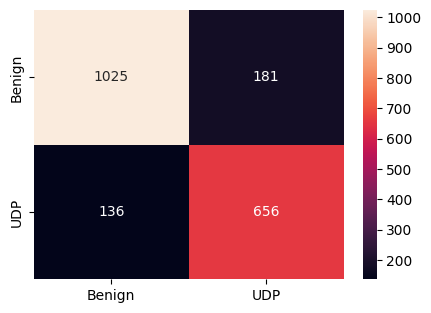

In [58]:
folder("results/cv/")

for file in file_list:
    print(file)
    feature=["ts","Label"]
    train=file
    test=file
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/cv/{file_list[file]}_VAL_TS.csv"
    target_names=["Benign",file_list[file]]
    ML_CV(train,test,output_csv,feature,file_list[file],0)   


./csvs/MB-UDP-2.csv
['pck_size', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  DT    1        1       0.999  1      0.999  0.999  1        0         0
 1  UDP           0    2     0  DT    1        1       1      1      1      1      1        0.016     0
 2  UDP           0    3     0  DT    1        1       1      1      1      1      1        0.016     0
 3  UDP           0    4     0  DT    1        1       0.999  1      0.999  0.999  1        0         0
 4  UDP           0    5     0  DT    1        1       1      1      1      1      1        0         0
 5  UDP           0    6     0  DT    1        1       1      1      1      1      1        0         0
 6  UDP           0    7     0  DT    1        1       0.999  1      0.999  0.999  1        0.004     0
 7  UDP       

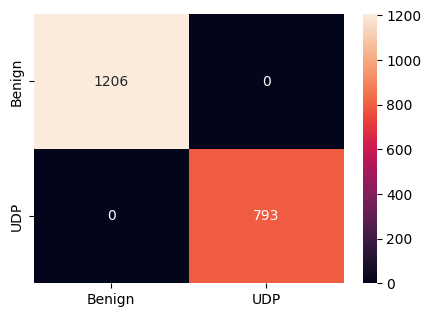

In [59]:
folder("results/cv/")

for file in file_list:
    print(file)
    feature=["pck_size","Label"]
    train=file
    test=file
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/cv/{file_list[file]}_VAL_Size.csv"
    target_names=["Benign",file_list[file]]
    ML_CV(train,test,output_csv,feature,file_list[file],0)   


# Kitsune Mirai

In [60]:
file_list={'./csvs/Kitsune_Mirai_FE.csv':"Mirai"}

./csvs/Kitsune_Mirai_FE.csv
['pck_size', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  Mirai         0    1     0  DT    0.899    0.918   0.804  0.918  0.843  0.689  0.918    0.173     0.016
 1  Mirai         0    2     0  DT    0.897    0.916   0.803  0.916  0.841  0.686  0.916    0.158     0
 2  Mirai         0    3     0  DT    0.899    0.918   0.803  0.918  0.842  0.688  0.918    0.155     0
 3  Mirai         0    4     0  DT    0.897    0.915   0.801  0.915  0.84   0.683  0.915    0.173     0.016
 4  Mirai         0    5     0  DT    0.899    0.919   0.804  0.919  0.843  0.689  0.919    0.157     0
 5  Mirai         0    6     0  DT    0.9      0.92    0.806  0.92   0.844  0.692  0.92     0.17      0.016
 6  Mirai         0    7     0  DT    0.899    0.918   0.806  0.918  0.844  0.692  0.918    0.173 

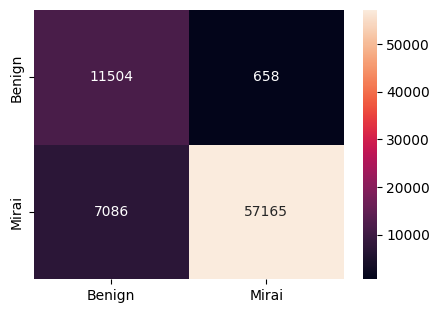

In [61]:
folder("results/cv/")

for file in file_list:
    print(file)
    feature=["pck_size","Label"]
    train=file
    test=file
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/cv/{file_list[file]}_VAL_size.csv"
    target_names=["Benign",file_list[file]]
    ML_CV(train,test,output_csv,feature,file_list[file],0)   


./csvs/Kitsune_Mirai_FE.csv
['ts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  Mirai         0    1     0  DT    0.997    0.99    0.998  0.99   0.994  0.988  0.99     0.149     0
 1  Mirai         0    2     0  DT    0.997    0.99    0.998  0.99   0.994  0.988  0.99     0.122     0.002
 2  Mirai         0    3     0  DT    0.997    0.99    0.998  0.99   0.994  0.988  0.99     0.125     0.003
 3  Mirai         0    4     0  DT    0.997    0.989   0.998  0.989  0.993  0.987  0.989    0.141     0
 4  Mirai         0    5     0  DT    0.997    0.99    0.998  0.99   0.994  0.988  0.99     0.141     0
 5  Mirai         0    6     0  DT    0.997    0.99    0.998  0.99   0.994  0.989  0.99     0.111     0.016
 6  Mirai         0    7     0  DT    0.997    0.99    0.998  0.99   0.994  0.987  0.99     0.13      0.

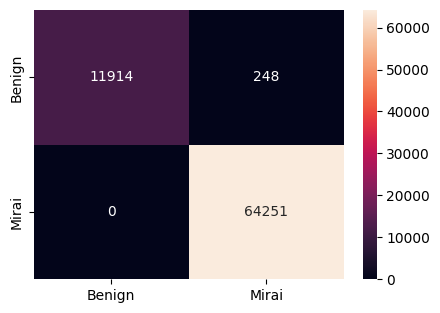

In [62]:
folder("results/cv/")

for file in file_list:
    print(file)
    feature=["ts","Label"]
    train=file
    test=file
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/cv/{file_list[file]}_VAL_ts.csv"
    target_names=["Benign",file_list[file]]
    ML_CV(train,test,output_csv,feature,file_list[file],0)   


In [63]:
# Kitsune Mirai

In [64]:
file_list={'./csvs/Video_Injection.csv':"VI"}

./csvs/Video_Injection.csv
['ts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  VI            0    1     0  DT    0.988    0.92    0.933  0.92   0.926  0.852  0.92     9.318     0.031
 1  VI            0    2     0  DT    0.989    0.921   0.933  0.921  0.927  0.854  0.921    9.025     0.028
 2  VI            0    3     0  DT    0.989    0.919   0.935  0.919  0.927  0.853  0.919    8.68      0.024
 3  VI            0    4     0  DT    0.988    0.919   0.934  0.919  0.926  0.852  0.919    8.19      0.031
 4  VI            0    5     0  DT    0.989    0.921   0.936  0.921  0.928  0.857  0.921    8.124     0.024
 5  VI            0    6     0  DT    0.989    0.92    0.934  0.92   0.927  0.854  0.92     8.613     0.031
 6  VI            0    7     0  DT    0.989    0.92    0.935  0.92   0.927  0.854  0.92     7

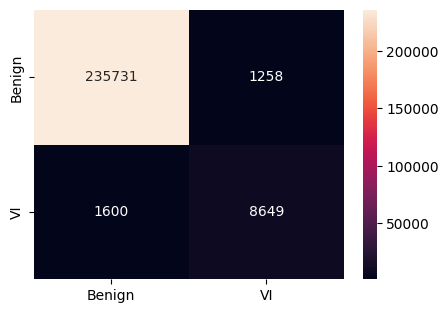

In [65]:
folder("results/cv/")

for file in file_list:
    print(file)
    feature=["ts","Label"]
    train=file
    test=file
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/cv/{file_list[file]}_VAL_ts.csv"
    target_names=["Benign",file_list[file]]
    ML_CV(train,test,output_csv,feature,file_list[file],0)   


./csvs/Video_Injection.csv
['pck_size', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  VI            0    1     0  DT    0.959      0.5   0.479    0.5  0.489      0    0.5    4.432     0.031
 1  VI            0    2     0  DT    0.958      0.5   0.479    0.5  0.489      0    0.5    5.442     0.031
 2  VI            0    3     0  DT    0.959      0.5   0.48     0.5  0.49       0    0.5    3.421     0.026
 3  VI            0    4     0  DT    0.959      0.5   0.48     0.5  0.49       0    0.5    6.406     0.047
 4  VI            0    5     0  DT    0.958      0.5   0.479    0.5  0.489      0    0.5    5.273     0.047
 5  VI            0    6     0  DT    0.958      0.5   0.479    0.5  0.489      0    0.5    5.027     0.031
 6  VI            0    7     0  DT    0.958      0.5   0.479    0.5  0.489      0    0.

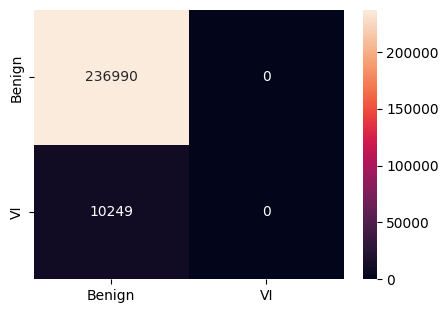

In [66]:
folder("results/cv/")

for file in file_list:
    print(file)
    feature=["pck_size","Label"]
    train=file
    test=file
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/cv/{file_list[file]}_VAL_size.csv"
    target_names=["Benign",file_list[file]]
    ML_CV(train,test,output_csv,feature,file_list[file],0)   

# Session vs Session

In [67]:
file_list={"UDP":['./csvs/MB-UDP-2.csv','./csvs/MB-UDP-4.csv']}

In [68]:
features=["pck_size","ts"]
ml_list={"ET":DecisionTreeClassifier()}

In [69]:
for train in (file_list):
    lines=[["Attack","Feature","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
    for dname in tqdm(features):

            target_names=["attack","benign"]
            feature=[dname, 'Label']
            
            output_csv=f"./results/compare/SS/ET_{train}_{dname}_same.csv"
            temp=ML(file_list[train][0],file_list[train][1],output_csv,feature,dname,train)  
            temp=temp[2:]
            temp=[train,dname,"ET"]+temp
            lines.append(temp)


    results = pd.DataFrame (lines[1:], columns = lines[0])
    print (tabulate(results, headers=list(results.columns)))




100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:31<00:00, 75.51s/it]

    Attack    Feature    ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  --------  ---------  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP       pck_size   ET    1        1       1      1      1      0.999  1        0.004     0.001
 1  UDP       ts         ET    0.866    0.865   0.858  0.865  0.861  0.722  0.865    0.066     0.006


In [70]:
file_list={"UDP":['./csvs/MB-UDP-2.csv','./csvs/MB-UDP-3.csv']}

In [71]:
for train in (file_list):
    lines=[["Attack","Feature","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
    for dname in tqdm(features):
            target_names=["attack","benign"]
            feature=[dname, 'Label']
            output_csv=f"./results/compare/SS/ET_{train}_{dname}_diffirent.csv"
            temp=ML(file_list[train][0],file_list[train][1],output_csv,feature,dname,train)  
            temp=temp[2:]
            temp=[train,dname,"ET"]+temp
            lines.append(temp)
    results = pd.DataFrame (lines[1:], columns = lines[0])
    print (tabulate(results, headers=list(results.columns)))




100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:16<00:00, 68.37s/it]

    Attack    Feature    ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  --------  ---------  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP       pck_size   ET    0.032    0.5     0.016  0.5    0.031  0      0.5      0.004     0.001
 1  UDP       ts         ET    0.526    0.566   0.508  0.566  0.379  0.017  0.566    0.065     0.007
